In [77]:
from bs4 import BeautifulSoup
from collections import Counter
from efficient_apriori import apriori
from gensim.models import CoherenceModel
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

import gensim.corpora as corpora
import gensim
import html
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import wandb

In [63]:
# Read the data
df_comments = pd.read_pickle('./sample_datasets/df_comments_sample.pkl')
df_posts = pd.read_pickle('./sample_datasets/df_posts_sample.pkl')
# df_post_links = pd.read_pickle('./sample_datasets/df_postlinks_sample.pkl')
df_tags = pd.read_pickle('./sample_datasets/df_tags_sample.pkl')
df_users = pd.read_pickle('./sample_datasets/df_users_sample.pkl')

In [67]:
df_posts['Tags'].head(2)

46115485    <python><python-2.7><csv>
42580730    <python><image><selenium>
Name: Tags, dtype: string

### Finding frequent itemset of Tags

In [68]:
# Filter posts to include only those with PostTypeId == 1
df_posts = df_posts[df_posts['PostTypeId'] == 1]

# Function to tokenize tags
def tokenize_tags(tag_string):
    # Using regular expression to find all words within < >
    return re.findall(r'<(.*?)>', tag_string)

# Apply the function to the Tags column
df_posts['TokenizedTags'] = df_posts['Tags'].apply(tokenize_tags)

C:\Users\pih\AppData\Local\Temp\ipykernel_23032\147595052.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posts['TokenizedTags'] = df_posts['Tags'].apply(tokenize_tags)


In [70]:
# Prepare data for Apriori
te = TransactionEncoder()
te_ary = te.fit(df_posts['TokenizedTags']).transform(df_posts['TokenizedTags'])
df_te = pd.DataFrame(te_ary, columns=te.columns_)

# Applying Apriori
frequent_itemsets = apriori(df_te, min_support=0.01, use_colnames=True)

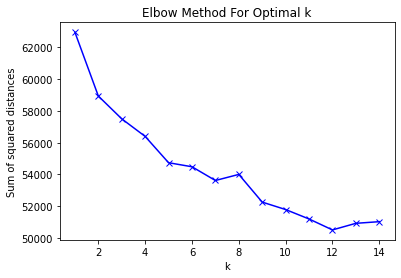

In [78]:
# Calculate sum of squared distances
ssd = []
K = range(1,15)  # Adjust the range based on your dataset
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_te)
    ssd.append(km.inertia_)

# Plotting the "Elbow"
plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [79]:
silhouette_scores = []
K = range(2,15)  # It starts from 2 as silhouette score cannot be calculated for a single cluster
for k in K:
    km = KMeans(n_clusters=k)
    clusters = km.fit_predict(df_te)
    score = silhouette_score(df_te, clusters)
    silhouette_scores.append(score)

# Plotting the results
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Each k')
plt.show()

In [ ]:
for min_support in [0.05, 0.03, 0.01, 0.005]:  # Example values
    frequent_itemsets = apriori(df_te, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)  # Keeping min_confidence fixed at 0.2
    print(f"Min Support: {min_support}, Number of Rules: {len(rules)}")

Proposing a way to identift Subject Matter Experts on Forum Based Platforms

Assign tags to topics:
- Topic modeling (or freq itemset)

Create User-level DataFrame
- Make normalized topic modelling distribution vector (summing to 100%) for every user

K-means Clustering to find users that engage in similar topics
- 

### Preprocess text

In [ ]:
def preprocess_text(text, use_lemmatize=True):
    # Decode HTML entities
    text = html.unescape(text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())

    words = text.split()

    # removal of stopwords
    words = [word for word in words if word not in stopwords.words('english')]

    if use_lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

    text = ' '.join(words)
    
    return text

In [ ]:
# WandB Timeeee
wandb.login()

In [ ]:
# Define apply_lda_and_log function with run_name parameter
def apply_topic_modeling_and_log(df, use_lemmatize, run_name, ngram_range=(1, 1), max_features=2000):
    # Start a new WandB run with the specified name
    wandb.init(project="stackexchange_politics", entity="s223730", name=run_name)

    # Preprocess Title, Body, and Tags
    df['Title'] = df['Title'].apply(lambda x: preprocess_text(x, use_lemmatize))
    df['Body'] = df['Body'].apply(lambda x: preprocess_text(x, use_lemmatize))
    df['Tags'] = df['Tags'].apply(lambda x: preprocess_text(x, use_lemmatize))


    # Combine Title, Body, and Tags with specified weight for Tags
    # We Keep the original order (title, body, tags) as it reflects the natural flow of information
    # Include dynamic tag weighting in CombinedText
    df['CombinedText'] = df.apply(
        lambda x: x['Title'] + ' ' + x['Body'] + ' ' + (' '.join(x['Tags']) * calculate_tag_weight(x['Tags'], tag_frequencies)),
        axis=1
    )
    # Create a Dictionary and Corpus needed for Topic Modeling
    words = [doc.split() for doc in df['CombinedText']]
    id2word = corpora.Dictionary(words)
    corpus = [id2word.doc2bow(text) for text in words]

    # Apply TF-IDF with the specified max_features
    # ngram_range=(1, 2) for bi-grams, (1, 3) for tri-grams, and (2, 2) for only bi-grams
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['CombinedText'])

    # Apply LDA and NMF for different numbers of topics
    # Prepare a structured dictionary to store results with n_topics as part of the key
    all_topics_results = {}
    for n_topics in [5, 10, 15, 20]:
        
        # LDA
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
        lda.fit(tfidf_matrix)

        # Extract Topic Distributions for LDA
        lda_topic_distributions = lda.transform(tfidf_matrix)

        # Normalize LDA Topic Distributions
        lda_normalized = np.array(lda_topic_distributions) / np.sum(lda_topic_distributions, axis=1)[:, None]

        # Calculate Coherence Score
        lda_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=0)
        coherence_model_lda = CoherenceModel(model=lda_gensim, texts=words, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()

        # Calculate LDA Perplexity
        lda_perplexity = lda.perplexity(tfidf_matrix)

        # Log Coherence and Perplexity Score
        wandb.log({"coherence_score": coherence_lda, "perplexity_score": lda.perplexity(tfidf_matrix)})
        
        # Extract and log the top words for each topic as a table
        feature_names = tfidf_vectorizer.get_feature_names_out()
        top_words_data = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
            top_words_data.append([f"Topic {topic_idx}"] + top_words)

        # Create a WandB Table with top words data
        columns = ["Topic"] + [f"Word {i+1}" for i in range(10)]
        top_words_table = wandb.Table(data=top_words_data, columns=columns)
        
        # Log the table to WandB
        wandb.log({f"n_topics_{n_topics}_lemmatize_{str(use_lemmatize)}_weight_{tags_weighting}": top_words_table})

        # NMF
        nmf_model = NMF(n_components=n_topics, random_state=0)
        nmf_W = nmf_model.fit_transform(tfidf_matrix)

        # Normalize NMF Topic Distributions (nmf_W is already the topic distribution matrix)
        nmf_normalized = np.array(nmf_W) / np.sum(nmf_W, axis=1)[:, None]

        nmf_H = nmf_model.components_

        # Calculate NMF Reconstruction Error
        nmf_reconstruction_error = np.linalg.norm(tfidf_matrix - nmf_W.dot(nmf_H))

        # Log the top words for each topic for NMF
        nmf_top_words_data = []
        for topic_idx, topic in enumerate(nmf_H):
            top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
            nmf_top_words_data.append([f"Topic {topic_idx}"] + top_words)

        nmf_top_words_table = wandb.Table(data=nmf_top_words_data, columns=columns)
        wandb.log({f"nmf_n_topics_{n_topics}": nmf_top_words_table})

        # Store the results including perplexity and reconstruction error
        all_topics_results[f"{run_name}_n_topics_{n_topics}"] = {
            'lda_normalized': lda_normalized,
            'nmf_normalized': nmf_normalized,
            'lda_coherence': coherence_lda,
            'lda_perplexity': lda_perplexity,
            'nmf_reconstruction_error': nmf_reconstruction_error,
            'lda_top_words': top_words_data,
            'nmf_top_words': nmf_top_words_data
        }
        
    # Close WandB run
    wandb.finish()

    # Return the topic distributions
    return all_topics_results

### Running different LDA configurations

In [ ]:
# Define your parameter ranges
use_lemmatize_options = [False, True]
ngram_range_options = [(1, 1), (1, 2), (1, 3)]

# Store the results for each n_topics uniquely
all_results = {}

# Iterate over the combinations of other options
for use_lemmatize, ngram_range in itertools.product(use_lemmatize_options, ngram_range_options):
    # Convert ngram_range tuple to string format
    ngram_range_str = '_'.join(map(str, ngram_range))

    # Construct a unique run name for this combination
    run_name = f"Run_lemmatize_{use_lemmatize}_ngram_{ngram_range_str}_maxfeat_2000"

    # Run the function and get the results
    topics_results = apply_topic_modeling_and_log(
        questions_df, 
        use_lemmatize, 
        run_name, 
        ngram_range, 
        max_features=2000
    )

    # Update all_results to include these structured results
    all_results.update(topics_results)

In [ ]:
# Save the results to a file or handle them as needed
# For example, saving to a pickle file
import pickle
with open('topic_modeling_results_n_topics_SO.pkl', 'wb') as f:
    pickle.dump(all_results, f)